# Training Notebook

Authored by [Mann Acharya](https://github.com/mach-12/)


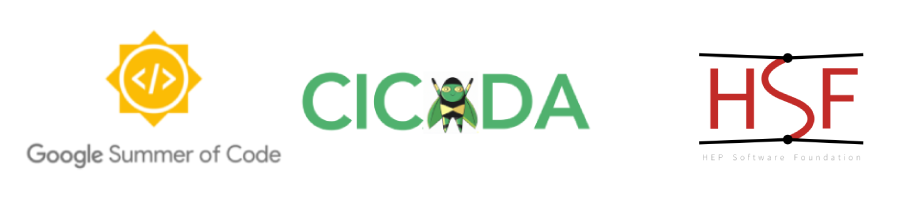

In this solution notebook we focus on these key tasks:

- Select and implement a CNN architecture using Keras.
- Perform hyperparameter tuning with Optuna for optimal model fit.
- Set up TensorBoard for experiment tracking.
- Save the best-performing model.


## Table of Contents


1. [Imports](#imports)
2. [Loading Dataset](#loading-dataset)
3. [Model Architecture](#model-architecture)
4. [Hyperparameter Tuning](#hyperparameter-tuning)
   - [Running Script](#running-script)
5. [Viewing Results using TensorBoard](#viewing-results-using-tensorboard)
   - [Best Parameters](#best-parameters)
6. [Dumping Best Hyper-parameters](#dumping-best-hyper-parameters)


## Imports



In [ ]:
import keras
from keras.models import Model

import optuna
from optuna_integration import TensorBoardCallback
from scripts.model import AutoencoderModel, ClassifierModel
from scripts.dataset_loader import TrainingDatasetLoader

from scripts.model_plots import create_neural_network_visualization

from scripts.utils import save_params_to_yaml

## Loading Dataset


In [3]:
loader = TrainingDatasetLoader(batch_size=32, test_size=0.2, seed=200)
(train_dataset, test_dataset, images_train, images_test, labels_train, labels_test) = (
    loader.load_training_dataset()
)

NUM_CLASSES = 2

## Model Architecture


We initialize the `AutoencoderModel`, and there is also a `ClassifierModel`. The approach is inspired by the general workings and lessons from building a Variational Autoencoder. Let's see how the pipeline works:

1. A `16x16` image enters the `AutoencoderModel`.

2. **Encoding Phase:** We use a **2D convolution**, doubling the number of filters while keeping the same kernel size. This means the dimensions of the output image are reduced by half, while the number of features doubles, effectively representing the same image with more abstract features.

3. We then apply a **downsampling operation** using the `MaxPooling2D` layer, which allows only the most prominent features to pass through.
4. The output is **flattened** and passed through a **latent layer**, which captures the core features of the data that matter most. A **dropout layer** is added to prevent overfitting when constructing this latent space. Through experiments, we determine the best value for dropout.

5. We **upsample and reconstruct** the image back to `16x16` using `Conv2DTranspose` filters. A **sigmoid activation** is applied at the end, returning the final image embeddings.

6. These **image embeddings** are then passed into the `ClassifierModel`, which consists of **8 dense units** with a **softmax activation**. This model classifies the image into two categories:
   - **Label 0:** Background
   - **Label 1:** Signal

All of these **hyperparameters**—`filters`, `latent_dim`, `kernel_size`, and `dropout_rate`—will be **tuned and tested** to find the optimal values!


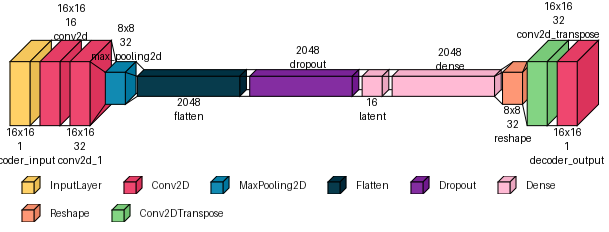

In [4]:
test_autoencoder_model = AutoencoderModel(
    input_shape=(16, 16, 1), filters=16, latent_dim=16, kernel_size=3, dropout_rate=0.0
).get_model()


create_neural_network_visualization(test_autoencoder_model, name="autoencoder")

Model Architecture Image saved to './plots/autoencoder_architecture.png'


/opt/homebrew/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


## Hyperparameter Tuning


In [5]:
# We can define an Optuna Objective to store suggestions for our tuning study


def objective(trial):
    filters = trial.suggest_int("filters", 16, 64, step=16)
    latent_dim = trial.suggest_int("latent_dim", 16, 64, step=16)
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Build the autoencoder and classifier using the suggested hyperparameters
    autoencoder = AutoencoderModel(
        input_shape=(16, 16, 1),
        filters=filters,
        latent_dim=latent_dim,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
    ).get_model()

    encoder = Model(autoencoder.input, autoencoder.get_layer("latent").output)

    classifier_model = ClassifierModel(encoder, NUM_CLASSES)

    # Compile the model with the suggested learning rate
    optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    classifier_model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    epochs = 100
    history = classifier_model.fit(
        train_dataset, epochs=epochs, validation_data=test_dataset, verbose=0
    )

    # Return the best validation accuracy as the objective value
    best_val_acc = max(history.history["val_accuracy"])
    return best_val_acc

### Running Script


In [6]:
# Set up the TensorBoard callback from Optuna
# Referred from: https://github.com/optuna/optuna-examples/blob/main/tensorboard/tensorboard_simple.py
tensorboard_callback = TensorBoardCallback("logs/", metric_name="accuracy")


study = optuna.create_study(direction="maximize")
study.optimize(
    objective,
    n_trials=20,
    callbacks=[tensorboard_callback],
)

print("Best trial:")
best_trial = study.best_trial
print("  Best Validation Accuracy: ", best_trial.value)
print("  Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

/var/folders/59/q2yb2fpj1h36gmjgd793x7_w0000gn/T/ipykernel_9137/1024502627.py:3: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
  tensorboard_callback = TensorBoardCallback("logs/", metric_name="accuracy")
[I 2025-03-04 21:10:41,801] A new study created in memory with name: no-name-6e3be784-3f58-4b28-8152-280cad7768c8
[I 2025-03-04 21:10:47,548] Trial 0 finished with value: 1.0 and parameters: {'filters': 32, 'latent_dim': 64, 'kernel_size': 3, 'dropout_rate': 0.1, 'learning_rate': 0.0009820466966219334}. Best is trial 0 with value: 1.0.
[I 2025-03-04 21:10:52,088] Trial 1 finished with value: 1.0 and parameters: {'filters': 16, 'latent_dim': 64, 'kernel_size': 3, 'dropout_rate': 0.5, 'learning_rate': 0.00039922905080119536}. Best is trial 0 with value: 1.0.
[I 2025-03-04 21:11:01,041] Trial 2 finished with value: 1.0 and parameters: {'filters': 32, 'latent_dim': 64, 'kernel_size': 5, 'dropout_rate': 0.5, 'learn

Best trial:
  Best Validation Accuracy:  1.0
  Best Hyperparameters:
    filters: 32
    latent_dim: 64
    kernel_size: 3
    dropout_rate: 0.1
    learning_rate: 0.0009820466966219334


## Viewing Results using TensorBoard




You can launch **TensorBoard** for exploring logs of the experimentation.

To launch, Use the inline magic function

```bash
%load_ext tensorboard
%tensorboard --logdir logs
```

OR, In the root of the repository run the below command

````
tensorboard --logdir logs```
````


### Best Parameters

We can the best parameters obtained in the training run and explore more in the dashboard

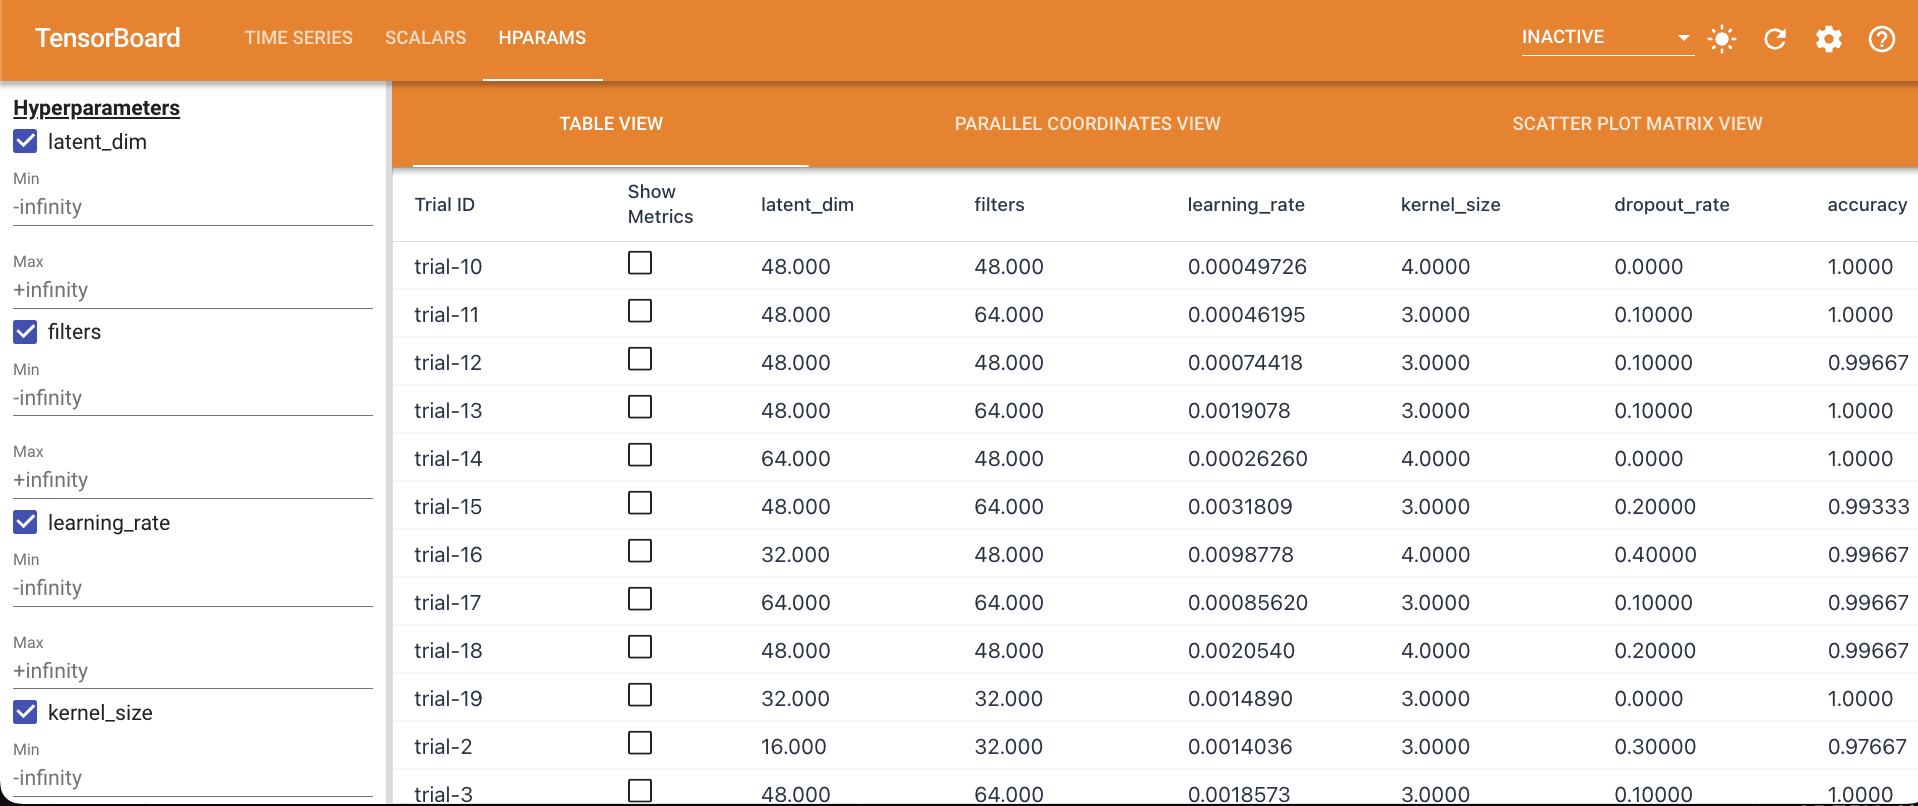

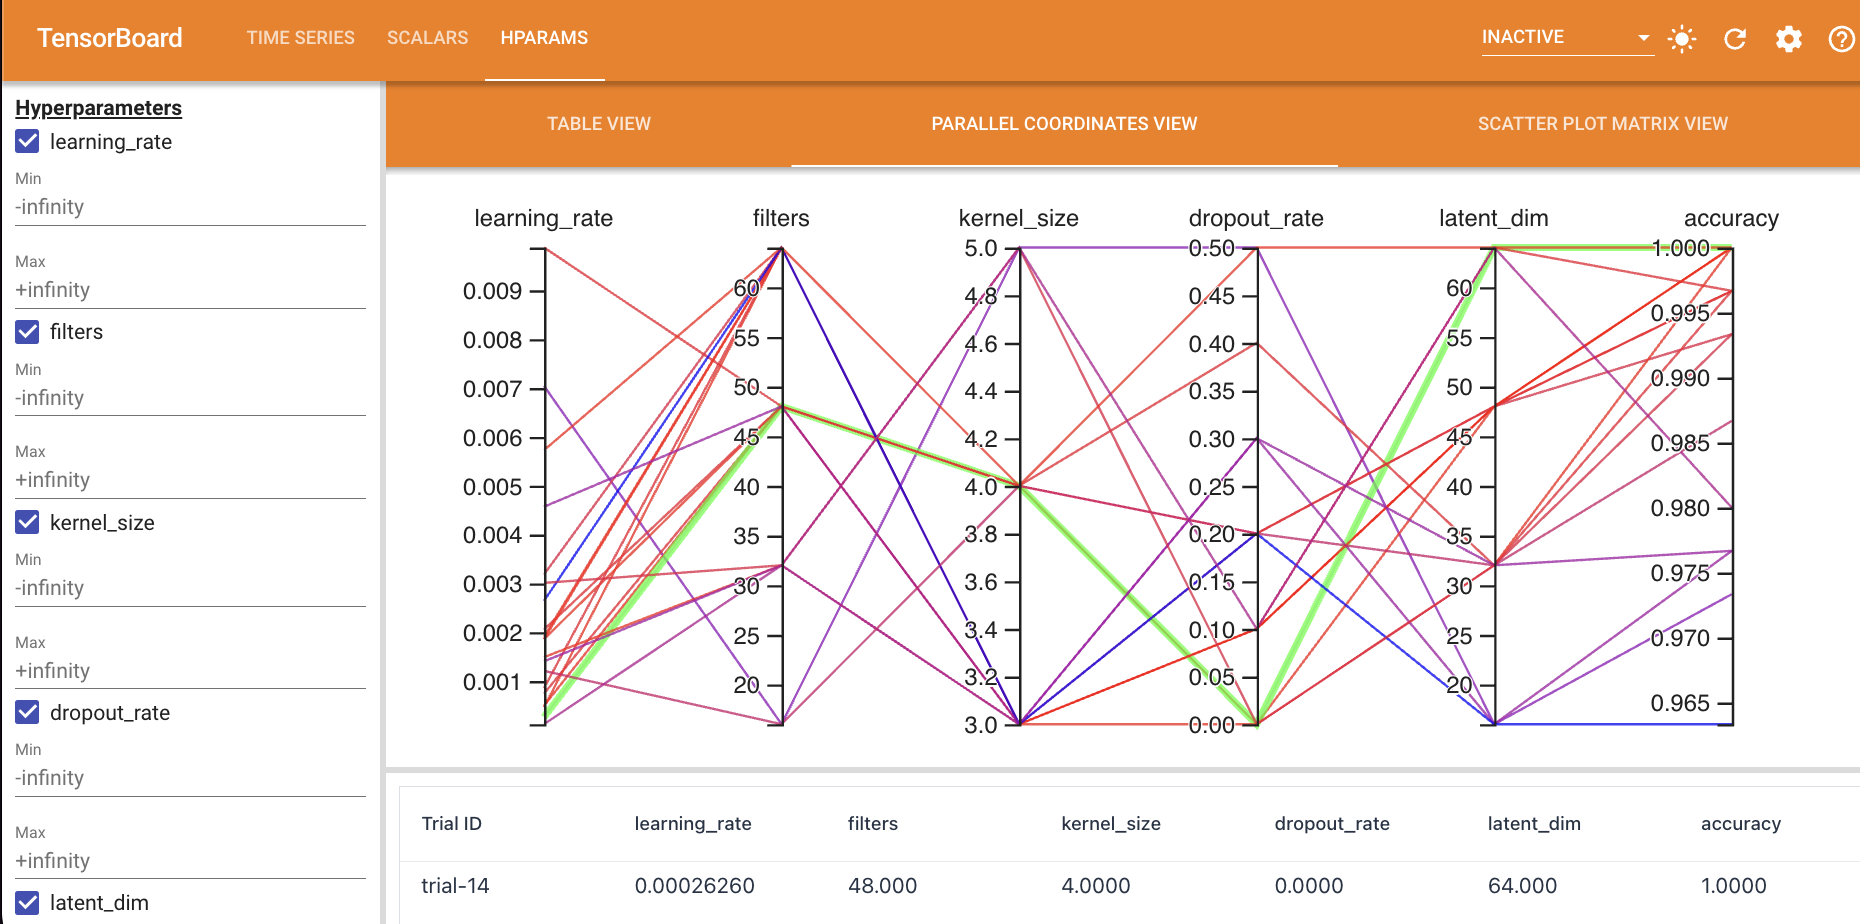

## Dumping Best Hyper-parameters


We are saving the optimal training configuration to a `.yaml` file, ensuring our experiments are easily reproducible across notebooks. This prevents us from scattering hardcoded values throughout our code, making it more maintainable.


In [7]:
best_params = best_trial.params
save_params_to_yaml(best_params)